Mounted at /content/drive
Device: cuda

[PROCESS] 1. Menyiapkan Dataset A...
   -> Scanning Root: train | Kelas Utama: ['Benign', 'InSitu', 'Invasive', 'Normal']
   -> Scanning Root: val | Kelas Utama: ['Benign', 'InSitu', 'Invasive', 'Normal']
   -> Scanning Root: test | Kelas Utama: ['Benign', 'InSitu', 'Invasive', 'Normal']

[PROCESS] 2. Menyiapkan Breakhis (Deep Scan)...
   -> Scanning Root: Breakhis_200x | Kelas Utama: ['benign', 'malignant']
   Total gambar Breakhis ditemukan: 2013

[PROCESS] 3. Menggabungkan Dataset...
   Train Size : 1991 (A + Breakhis)
   Val Size   : 342 (A + Breakhis)
   Test Size  : 80 (Dataset A Only)

[INFO] Mapping Kelas: {'benign': 0, 'insitu': 1, 'invasive': 2, 'malignant': 3, 'normal': 4}
[MODEL] Loading Swin Transformer (Pretrained=False)...

   >> RUN 1 dimulai (Seed 42)...


   >> Run 1 Selesai. Best Val F1: 0.8427
   -> Result Run 1 (Test F1): 0.4885

[MODEL] Loading Swin Transformer (Pretrained=False)...

   >> RUN 2 dimulai (Seed 2024)...


   >> Run 2 Selesai. Best Val F1: 0.8260
   -> Result Run 2 (Test F1): 0.5215

[MODEL] Loading Swin Transformer (Pretrained=False)...

   >> RUN 3 dimulai (Seed 999)...


   >> Run 3 Selesai. Best Val F1: 0.8444
   -> Result Run 3 (Test F1): 0.4154


 HASIL AKHIR GABUNGAN (SWIN FROM SCRATCH) (Best Run: 2)
 Evaluasi pada Test Set Dataset A (Fair Comparison)


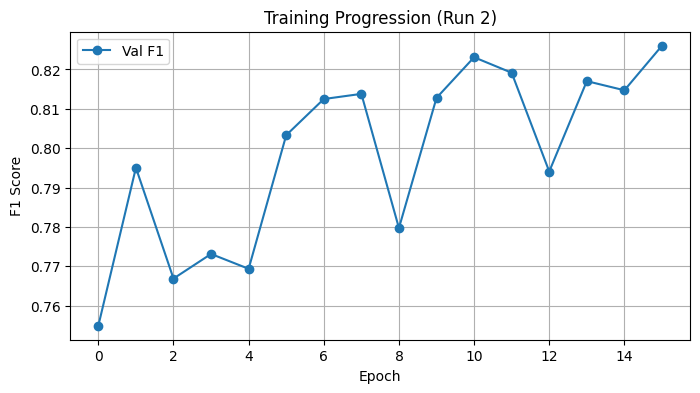

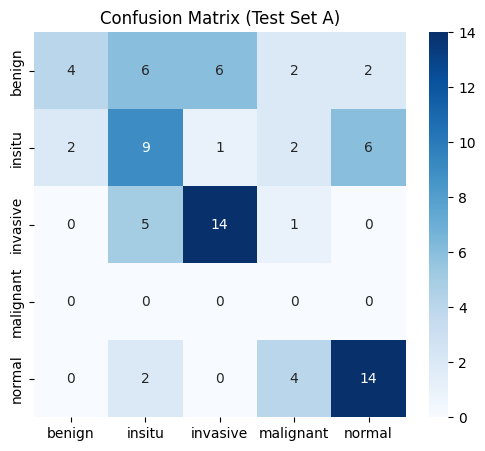


[CLASSIFICATION REPORT]
              precision    recall  f1-score   support

      benign       0.67      0.20      0.31        20
      insitu       0.41      0.45      0.43        20
    invasive       0.67      0.70      0.68        20
   malignant       0.00      0.00      0.00         0
      normal       0.64      0.70      0.67        20

    accuracy                           0.51        80
   macro avg       0.48      0.41      0.42        80
weighted avg       0.59      0.51      0.52        80



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
# ==============================================================================
#  FINAL ROBUST PIPELINE: COMBINED DATASETS (A + BREAKHIS)
#  Model: Swin Transformer (Training from Scratch / No Transfer Learning)
# ==============================================================================

import subprocess
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive

# --- 1. INSTALL LIBRARY ---
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import timm
except ImportError:
    print("Installing timm...")
    install('timm')
    import timm

# --- 2. KONFIGURASI PATH ---
# Sesuaikan dengan lokasi folder Anda di Google Drive
PATH_DATASET_A = '/content/drive/MyDrive/Breastcancerimager'
PATH_BREAKHIS  = '/content/drive/MyDrive/Breakhis_200x'

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 16
NUM_RUNS = 3
SEEDS = [42, 2024, 999]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

print(f"Device: {DEVICE}")

# ==============================================================================
#  BAGIAN 1: DATA MANAGER (DEEP RECURSIVE SCAN)
# ==============================================================================

class CombinedDataManager:
    def __init__(self, path_a, path_breakhis):
        self.path_a = path_a
        self.path_b = path_breakhis

    def get_df_recursive(self, folder_path):
        if not os.path.exists(folder_path):
            print(f"[WARNING] Path tidak ditemukan: {folder_path}")
            return pd.DataFrame(columns=['filepath', 'label'])

        filepaths = []
        labels = []

        try:
            classes = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
        except:
            return pd.DataFrame(columns=['filepath', 'label'])

        print(f"   -> Scanning Root: {os.path.basename(folder_path)} | Kelas Utama: {classes}")

        for label in classes:
            class_path = os.path.join(folder_path, label)
            count_per_class = 0
            for root, dirs, files in os.walk(class_path):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                        fpath = os.path.join(root, file)
                        filepaths.append(fpath)
                        labels.append(label.lower())
                        count_per_class += 1

        df = pd.DataFrame({'filepath': filepaths, 'label': labels})
        return df

    def prepare_combined_data(self):
        print("\n[PROCESS] 1. Menyiapkan Dataset A...")
        df_train_a = self.get_df_recursive(os.path.join(self.path_a, 'train'))
        df_val_a   = self.get_df_recursive(os.path.join(self.path_a, 'val'))
        df_test_a  = self.get_df_recursive(os.path.join(self.path_a, 'test'))

        print("\n[PROCESS] 2. Menyiapkan Breakhis (Deep Scan)...")
        df_full_b = self.get_df_recursive(self.path_b)

        if not df_full_b.empty:
            print(f"   Total gambar Breakhis ditemukan: {len(df_full_b)}")
            X = df_full_b['filepath']
            y = df_full_b['label']
            try:
                df_train_b, df_val_b = train_test_split(df_full_b, test_size=0.15, stratify=y, random_state=42)
            except ValueError:
                df_train_b, df_val_b = train_test_split(df_full_b, test_size=0.15, random_state=42)
        else:
            print("   [ERROR] Breakhis masih kosong! Pastikan path benar.")
            df_train_b = pd.DataFrame()
            df_val_b = pd.DataFrame()

        print("\n[PROCESS] 3. Menggabungkan Dataset...")
        final_train = pd.concat([df_train_a, df_train_b], ignore_index=True)
        final_val = pd.concat([df_val_a, df_val_b], ignore_index=True)
        final_test = df_test_a

        print(f"   Train Size : {len(final_train)} (A + Breakhis)")
        print(f"   Val Size   : {len(final_val)} (A + Breakhis)")
        print(f"   Test Size  : {len(final_test)} (Dataset A Only)")

        return final_train, final_val, final_test

class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None, class_map=None):
        self.df = df
        self.transform = transform
        self.class_map = class_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filepath']
        label_str = row['label']

        if label_str in self.class_map:
            label = self.class_map[label_str]
        else:
            label = 0

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), label

transforms_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==============================================================================
#  BAGIAN 2: MODEL (SWIN TRANSFORMER - FROM SCRATCH)
# ==============================================================================

class SEBlock1D(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock1D, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.fc(x)
        return x * y

class SwinTransformer_Custom(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(SwinTransformer_Custom, self).__init__()

        # 1. Load Backbone: Swin Transformer Tiny
        # PENTING: pretrained=False (Training from scratch)
        print(f"[MODEL] Loading Swin Transformer (Pretrained={pretrained})...")
        self.backbone = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0 # Kita hanya ambil fitur, bukan klasifikasi bawaan
        )

        # Ambil ukuran fitur output dari backbone (biasanya 768 untuk Swin Tiny)
        num_features = self.backbone.num_features

        # 2. Attention Module
        self.attention = SEBlock1D(num_features)

        # 3. Classifier Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(num_features),
            nn.Dropout(0.3),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        # Swin Output: (Batch, Num_Features) karena num_classes=0 otomatis pooling
        features = self.backbone(x)

        # Apply Custom Attention
        att_features = self.attention(features)

        # Final Classification
        out = self.classifier(att_features)
        return out

# ==============================================================================
#  BAGIAN 3: TRAINING LOOP
# ==============================================================================

def train_one_run(run_id, train_loader, val_loader, test_loader, num_classes, seed):
    # Set Random Seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # --- MODEL INITIALIZATION (NO TRANSFER LEARNING) ---
    model = SwinTransformer_Custom(num_classes=num_classes, pretrained=False).to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    best_f1 = 0.0
    history = {'loss': [], 'val_f1': []}
    model_save_path = f"best_swin_scratch_run_{run_id}.pth"

    print(f"\n   >> RUN {run_id} dimulai (Seed {seed})...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0

        for imgs, lbls in tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False):
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Loop
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(DEVICE)
                out = model(imgs)
                _, p = torch.max(out, 1)
                preds.extend(p.cpu().numpy())
                targets.extend(lbls.numpy())

        val_f1 = f1_score(targets, preds, average='weighted')
        history['loss'].append(train_loss/len(train_loader))
        history['val_f1'].append(val_f1)

        scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), model_save_path)

    print(f"   >> Run {run_id} Selesai. Best Val F1: {best_f1:.4f}")

    # --- FINAL TEST EVALUATION ---
    model.load_state_dict(torch.load(model_save_path, weights_only=True))
    model.eval()

    t_preds, t_targets, t_probs = [], [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)
            _, p = torch.max(out, 1)
            t_preds.extend(p.cpu().numpy())
            t_targets.extend(lbls.numpy())
            t_probs.extend(probs.cpu().numpy())

    final_test_f1 = f1_score(t_targets, t_preds, average='weighted')

    return {
        'run_id': run_id,
        'f1': final_test_f1,
        'history': history,
        'preds': t_preds,
        'targets': t_targets,
        'probs': np.array(t_probs)
    }

def analyze_final_results(results, class_map):
    best_res = max(results, key=lambda x: x['f1'])
    print(f"\n{'='*50}")
    print(f" HASIL AKHIR GABUNGAN (SWIN FROM SCRATCH) (Best Run: {best_res['run_id']})")
    print(f" Evaluasi pada Test Set Dataset A (Fair Comparison)")
    print(f"{'='*50}")

    # 1. Plot Grafik Training
    plt.figure(figsize=(8, 4))
    plt.plot(best_res['history']['val_f1'], marker='o', label='Val F1')
    plt.title(f'Training Progression (Run {best_res["run_id"]})')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(best_res['targets'], best_res['preds'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_map.keys(), yticklabels=class_map.keys())
    plt.title('Confusion Matrix (Test Set A)')
    plt.show()

    # 3. Text Report
    print("\n[CLASSIFICATION REPORT]")
    print(classification_report(best_res['targets'], best_res['preds'], target_names=class_map.keys()))

# ==============================================================================
#  MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # 1. Siapkan Data
    manager = CombinedDataManager(PATH_DATASET_A, PATH_BREAKHIS)
    train_df, val_df, test_df = manager.prepare_combined_data()

    if not train_df.empty and not test_df.empty:
        # 2. Setup Kelas & Dataloader
        classes = sorted(train_df['label'].unique())
        class_map = {k: v for v, k in enumerate(classes)}
        print(f"\n[INFO] Mapping Kelas: {class_map}")

        train_loader = DataLoader(BreastCancerDataset(train_df, transforms_train, class_map),
                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(BreastCancerDataset(val_df, transforms_val, class_map),
                                batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        test_loader = DataLoader(BreastCancerDataset(test_df, transforms_val, class_map),
                                 batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        # 3. Jalankan 3 Runs
        all_results = []
        for i, seed in enumerate(SEEDS):
            res = train_one_run(i+1, train_loader, val_loader, test_loader, len(classes), seed)
            all_results.append(res)
            print(f"   -> Result Run {i+1} (Test F1): {res['f1']:.4f}\n")

        # 4. Analisis
        analyze_final_results(all_results, class_map)
    else:
        print("\n[CRITICAL ERROR] Data kosong. Mohon periksa path Google Drive Anda.")

In [4]:
# ==============================================================================
# BAGIAN 4: VISUALISASI PREDIKSI DARI DATA TEST (SETELAH TRAINING)
# ==============================================================================

def visualize_test_predictions_swin(model, test_dataframe, class_map, num_samples=12):
    """
    Visualisasi hasil prediksi model Swin Transformer pada sampel acak dari test_df.
    """
    print(f"\n{'='*60}")
    print(f" VISUALISASI PREDIKSI: SWIN FROM SCRATCH (TEST SET A) ")
    print(f"{'='*60}")

    # 1. Setup Model
    model.eval()
    model.to(DEVICE)

    # Reverse class_map untuk mendapatkan nama dari index
    # Contoh: {0: 'benign', 1: 'insitu', ...}
    inv_class_map = {v: k for k, v in class_map.items()}

    # 2. Ambil Sampel Acak
    if len(test_dataframe) < num_samples:
        num_samples = len(test_dataframe)

    sample_df = test_dataframe.sample(n=num_samples).reset_index(drop=True)

    # Setup Plot Grid
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    # 3. Loop Prediksi & Plotting
    for i, row in sample_df.iterrows():
        img_path = row['filepath']
        true_label_str = row['label']

        try:
            # Load Original Image (untuk display)
            pil_img_raw = Image.open(img_path).convert('RGB')

            # Preprocess Image (untuk model) menggunakan transforms_val dari pipeline
            input_tensor = transforms_val(pil_img_raw).unsqueeze(0).to(DEVICE)

            # Prediksi
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)
                confidence, pred_idx = torch.max(probs, 1)

            pred_idx = pred_idx.item()
            conf_score = confidence.item() * 100
            pred_name = inv_class_map[pred_idx]

            # --- LOGIKA STATUS KEPARAHAN ---
            # Menyesuaikan label (asumsi: benign, normal, insitu, invasive)
            status_text = ""
            text_color = "black"

            p_name_lower = pred_name.lower()
            if 'normal' in p_name_lower or 'benign' in p_name_lower:
                status_text = "STATUS: AMAN / JINAK"
                text_color = "green"
            elif 'insitu' in p_name_lower:
                status_text = "STATUS: WASPADA (Tahap Awal)"
                text_color = "darkorange"
            elif 'invasive' in p_name_lower:
                status_text = "STATUS: BAHAYA (Kanker Ganas)"
                text_color = "red"
            else:
                status_text = f"STATUS: {pred_name.upper()}"

            # Cek Benar/Salah
            is_correct = (p_name_lower == true_label_str.lower())
            result_symbol = "✅" if is_correct else "❌"

            # Plotting
            ax = axes[i]
            ax.imshow(pil_img_raw)
            ax.set_axis_off()

            # Judul Gambar
            title = f"{result_symbol} Pred: {pred_name}\nTrue: {true_label_str}\nConf: {conf_score:.1f}%"
            ax.set_title(title, fontsize=11, fontweight='bold', pad=10)

            # Tambahkan Teks Status di bawah gambar
            ax.text(0.5, -0.12, status_text, color=text_color,
                    fontweight='bold', ha='center', transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        except Exception as e:
            print(f"Gagal memuat gambar {img_path}: {e}")
            axes[i].axis('off')

    # Sembunyikan subplot yang kosong
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# ==============================================================================
# EKSEKUSI VISUALISASI
# ==============================================================================
# Jalankan ini setelah training loop selesai.
# Kita akan mengambil model terbaik dari run terakhir atau run tertentu.

# Pastikan variabel ini tersedia
if 'all_results' in globals() and 'test_df' in globals():
    # 1. Ambil model terbaik berdasarkan F1 Score dari semua run
    best_run_idx = max(range(len(all_results)), key=lambda i: all_results[i]['f1'])
    best_run_id = all_results[best_run_idx]['run_id']

    # 2. Re-inisialisasi model dan load weights terbaik
    num_classes = len(class_map)
    final_model = SwinTransformer_Custom(num_classes=num_classes, pretrained=False).to(DEVICE)
    model_path = f"best_swin_scratch_run_{best_run_id}.pth"

    if os.path.exists(model_path):
        final_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print(f"Memuat model terbaik dari Run {best_run_id} untuk visualisasi.")

        # 3. Jalankan Visualisasi
        visualize_test_predictions_swin(final_model, test_df, class_map, num_samples=12)
    else:
        print(f"File model {model_path} tidak ditemukan.")
else:
    print("Selesaikan proses training (Main Execution) terlebih dahulu.")

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# ==============================================================================
# SISTEM PREDIKSI & SARAN MEDIS AI (KANKER PAYUDARA) - SWIN VERSION
# ==============================================================================

import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image

def get_medical_advice(pred_idx, confidence, class_map):
    """
    Fungsi untuk memberikan saran medis berdasarkan kelas prediksi.
    Mapping disesuaikan dengan urutan alfabetis dari class_map pipeline.
    """
    # Mendapatkan nama kelas berdasarkan index
    inv_class_map = {v: k for k, v in class_map.items()}
    pred_name = inv_class_map[pred_idx].lower()

    # Default values
    status = f"KONDISI: {pred_name.upper()}"
    color = "black"
    advice = "Saran tidak tersedia untuk kategori ini."

    # Logika berdasarkan nama kelas (lebih aman daripada index angka saja)
    if 'normal' in pred_name:
        status = "KONDISI: NORMAL (SEHAT)"
        color = "green"
        advice = (
            "✅ HASIL: Jaringan tampak sehat.\n"
            "SARAN: Pertahankan pola hidup sehat dan lakukan pemeriksaan rutin tahunan."
        )
    elif 'benign' in pred_name:
        status = "KONDISI: TUMOR JINAK (BENIGN)"
        color = "green"
        advice = (
            "✅ HASIL: Terdeteksi kelainan, namun kemungkinan besar JINAK.\n"
            "SARAN: Konsultasikan ke dokter untuk konfirmasi. Biasanya tidak berbahaya."
        )
    elif 'insitu' in pred_name:
        status = "⚠️ PERINGATAN: KANKER TAHAP AWAL (InSitu)"
        color = "darkorange"
        advice = (
            "⚠️ HASIL: Terdeteksi sel kanker yang belum menyebar (Early Stage).\n"
            "SARAN: SEGERA TEMUI DOKTER. Peluang kesembuhan sangat tinggi jika ditangani sekarang."
        )
    elif 'invasive' in pred_name:
        status = "🚨 BAHAYA: KANKER GANAS (Invasive)"
        color = "red"
        advice = (
            "🚨 HASIL KRITIS: Terdeteksi kanker yang berpotensi menyebar luas.\n"
            "SARAN: DARURAT. Segera kunjungi Onkolog (Ahli Kanker) untuk penanganan medis secepatnya."
        )

    return status, color, advice, pred_name.upper()

def visualize_medical_prediction(model, dataframe, class_map, num_samples=5):
    print(f"\n{'='*70}")
    print(f" SIMULASI DIAGNOSA AI & SARAN DOKTER (SWIN TRANSFORMER) ")
    print(f"{'='*70}")

    # 1. Setup
    model.eval()
    model.to(DEVICE) # Menggunakan DEVICE dari pipeline utama

    # Ambil sampel acak dari data test
    if len(dataframe) < num_samples: num_samples = len(dataframe)
    sample_df = dataframe.sample(n=num_samples).reset_index(drop=True)

    # 2. Loop Prediksi
    for i, row in sample_df.iterrows():
        img_path = row['filepath'] # Sesuai kolom di CombinedDataManager
        true_label = row['label'].upper()

        try:
            # Preprocess Image menggunakan transforms_val dari pipeline
            original_img = Image.open(img_path).convert('RGB')
            input_tensor = transforms_val(original_img).unsqueeze(0).to(DEVICE)

            # AI Inference
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1)
                confidence, pred_idx = torch.max(probs, 1)

            pred_idx = pred_idx.item()
            conf_score = confidence.item() * 100

            # Dapatkan Saran Medis
            status_text, status_color, advice_text, pred_label_name = get_medical_advice(pred_idx, conf_score, class_map)

            # --- VISUALISASI ---
            plt.figure(figsize=(12, 5))

            # Plot Gambar (Kiri)
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.axis('off')
            plt.title(f"Visual Scan Pasien #{i+1}", fontsize=12, fontweight='bold')

            # Plot Teks Saran (Kanan)
            plt.subplot(1, 2, 2)
            plt.axis('off')

            # Tentukan simbol untuk kecocokan diagnosa
            match_symbol = "✅ SESUAI" if pred_label_name.lower() == true_label.lower() else "⚠️ PERBEDAAN"

            text_display = (
                f"LABORATORIUM AI REPORT\n"
                f"{'='*30}\n"
                f"Diagnosa Asli (Dokter) : {true_label}\n"
                f"Prediksi Sistem AI    : {pred_label_name}\n"
                f"Tingkat Keyakinan      : {conf_score:.2f}%\n"
                f"Status Validasi        : {match_symbol}\n\n"
                f"KESIMPULAN:\n"
                f"{status_text}\n\n"
                f"SARAN MEDIS:\n"
                f"{advice_text}"
            )

            # Menggunakan font monospace agar tampilan seperti laporan lab
            plt.text(0, 0.5, text_display, fontsize=11, family='monospace', va='center',
                     bbox=dict(boxstyle="round,pad=1", facecolor='whitesmoke', alpha=0.5))

            plt.tight_layout()
            plt.show()
            print("-" * 100) # Separator horizontal di console

        except Exception as e:
            print(f"Error pada gambar {img_path}: {e}")

# ==============================================================================
# JALANKAN PROGRAM PREDIKSI
# ==============================================================================
# Mengambil model terbaik dari hasil training run sebelumnya
if 'all_results' in globals() and 'test_df' in globals():
    # Ambil run dengan F1 terbaik
    best_run_idx = max(range(len(all_results)), key=lambda i: all_results[i]['f1'])
    best_run_id = all_results[best_run_idx]['run_id']

    # Load model
    num_classes = len(class_map)
    final_viz_model = SwinTransformer_Custom(num_classes=num_classes, pretrained=False).to(DEVICE)
    model_weight_path = f"best_swin_scratch_run_{best_run_id}.pth"

    if os.path.exists(model_weight_path):
        final_viz_model.load_state_dict(torch.load(model_weight_path, map_location=DEVICE))

        # Jalankan simulasi untuk 5 pasien dari test_df
        visualize_medical_prediction(final_viz_model, test_df, class_map, num_samples=5)
    else:
        print(f"File weights {model_weight_path} tidak ditemukan.")
else:
    print("MOHON JALANKAN PROSES TRAINING TERLEBIH DAHULU.")

Output hidden; open in https://colab.research.google.com to view.